# Learning Koopman eigenfunctions on Slow manifold

The linearity, and thus the model performance, of a Koopman model can be analyzed by
comparing the linearity of the eigenfunctions evaluated on a test trajectory and the
prediction using the corresponding eigenvalue. This will be demonstrated in this
tutorial for a two-dimensional system evolving on a slow manifold. 

For detailed information we refer to
- Kaiser, Kutz & Brunton, _"Data-driven discovery of Koopman eigenfunctions for
control"_, Machine Learning: Science and Technology, Vol. 2(3), 035023, 2021,
- Korda & Mezic, _"Optimal construction of Koopman eigenfunctions for prediction and
control"_, IEEE Transactions on Automatic Control, Vol. 65(12), 2020.

In [1]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import slow_manifold
nonlinear_sys = slow_manifold(mu=-0.1, la=-1.0, dt=0.1)

### Collect training data

In [2]:
n_int = 1
n_pts = 51
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

X, Y = nonlinear_sys.collect_data_discrete(Xdat, n_int)

### Test trajectory

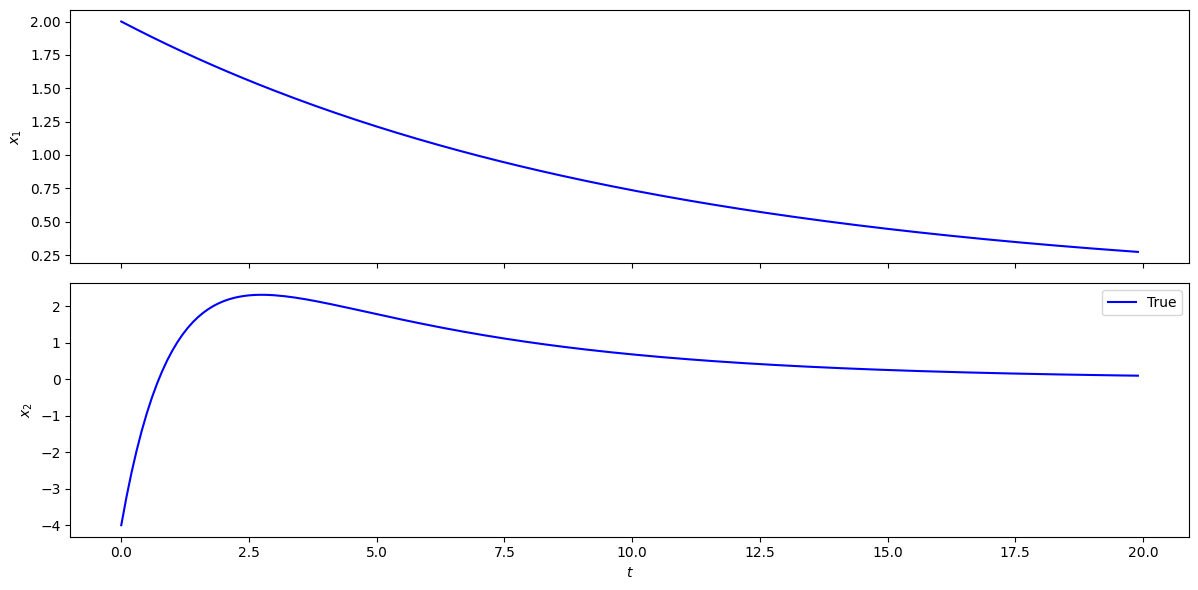

In [3]:
x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(12, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='blue', label='True')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='blue', label='True')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

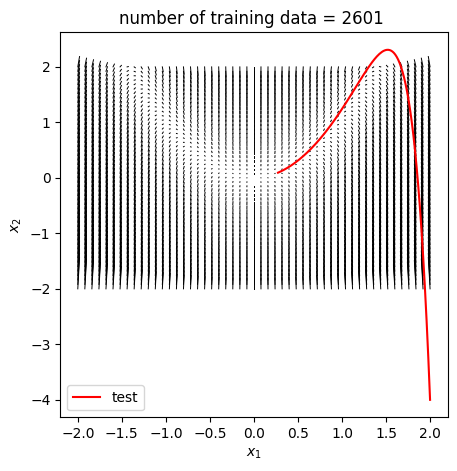

In [4]:
plt.figure(figsize=(5,5))
for i in range(X.shape[-1]):
    plt.plot([X[0,i], Y[0,i]], [X[1,i], Y[1,i]],'-k',lw=0.7,label=None)

# plot test trajectory
plt.plot(Xtest[:, 0], Xtest[:, 1],'-r',label='test')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(f"number of training data = {X.shape[-1]} ")
plt.legend(loc='best')

### Try EDMD with polynomial features on training data

In [5]:
regr = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model_edmd = pk.Koopman(observables=obsv, regressor=regr)
model_edmd.fit(X.T, y=Y.T, dt=nonlinear_sys.dt)

Koopman(observables=Polynomial(degree=3), regressor=EDMD())

In [6]:
koop_eigenvals = np.log(np.linalg.eig(model_edmd.A)[0])/nonlinear_sys.dt

print(f"koopman eigenvalues = {koop_eigenvals}")

koopman eigenvalues = [-2.99737262e+00 -2.09824757e+00 -1.99824841e+00 -1.19912253e+00
 -1.09912337e+00 -9.99124206e-01 -2.99997487e-01 -9.99991625e-02
  1.77635684e-14 -1.99998325e-01]


### Try NNDMD on training data

In [7]:
look_forward = 1
dlk_regressor = pk.regression.NNDMD(dt=nonlinear_sys.dt, look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[64] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=64, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=3))

# train the vanilla NN model
model = pk.Koopman(regressor=dlk_regressor)
model.fit(X.T, Y.T, dt=nonlinear_sys.dt)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=64,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [], 'input_size': 3,
                                        'output_size': 2},
                        config_encoder={'activations': 'swish',
                                        'hidden_sizes': [64, 64, 64],
                                        'input_size': 2, 'output_size': 3},
                        dt=0.1, lbfgs=True, normalize_std_factor=1.0,
                        trainer_kwargs={'max_epochs': 3}))

### Note: 

If you didn't find the model to converge, that's because LBFGS is not very robust. You can try again and hope it works again.

### Try NNDMD on training data but enforce the $A$ to be disspative

In [8]:
dlk_regressor_d = pk.regression.NNDMD(mode='Dissipative',
                                    dt=nonlinear_sys.dt,
                                    look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[64] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=64, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=3))

# train the dissipative NN model
model_d = pk.Koopman(regressor=dlk_regressor_d)
model_d.fit(X.T, Y.T, dt=nonlinear_sys.dt)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
d:\work\pykoopman\pykoopman\regression\_nndmd.py:877: UserWarning: Warning: no validation data prepared
  warn("Warning: no validation data prepared")
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_V

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=64,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [], 'input_size': 3,
                                        'output_size': 2},
                        config_encoder={'activations': 'swish',
                                        'hidden_sizes': [64, 64, 64],
                                        'input_size': 2, 'output_size': 3},
                        dt=0.1, lbfgs=True, mode='Dissipative',
                        normalize_std_factor=1.0,
                        trainer_kwargs={'max_epochs': 3}))

## Check the continuous eigenvalues

- You might notice that they are not really close to the ground truth, which was a bit
 disappointing.

 - We suspect that one-step loss is not enough to uniquely identify the set of
 Koopman triplets that corresponds to the ground truth.

In [9]:
koop_eigenvals = np.log(np.linalg.eig(model.A)[0])/nonlinear_sys.dt
print(f"koopman eigenvalues = {koop_eigenvals}")

koop_eigenvals = np.log(np.linalg.eig(model_d.A)[0])/nonlinear_sys.dt
print(f"koopman eigenvalues with dissipative enforcement = {koop_eigenvals}")

koopman eigenvalues = [-2.3751614   0.29565603 -0.09974468]
koopman eigenvalues with dissipative enforcement = [-0.25622052+1.1222951j -0.25622052-1.1222951j -0.09981874+0.j       ]


### Evaluate model performance on test trajectory

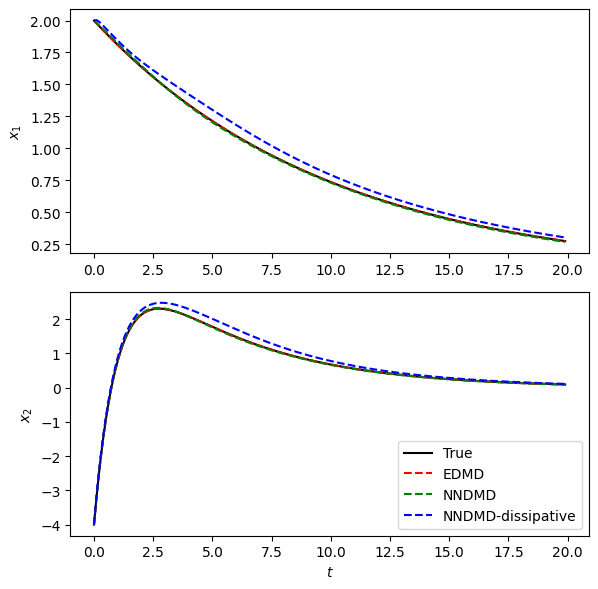

In [10]:

Xkoop_edmd = model_edmd.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop_edmd = np.vstack([x0[np.newaxis,:], Xkoop_edmd])

Xkoop_nn_d = model_d.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop_nn_d = np.vstack([x0[np.newaxis,:], Xkoop_nn_d])

Xkoop_nn = model.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop_nn = np.vstack([x0[np.newaxis,:], Xkoop_nn])

fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(6, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='k', label='True')
axs[0].plot(t, Xkoop_edmd[:, 0], '--r', label='EDMD')
axs[0].plot(t, Xkoop_nn[:, 0], '--g', label='NNDMD')
axs[0].plot(t, Xkoop_nn_d[:, 0], '--b', label='NNDMD-dissipative')

axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='k', label='True')
axs[1].plot(t, Xkoop_edmd[:, 1], '--r', label='EDMD')
axs[1].plot(t, Xkoop_nn[:, 1], '--g', label='NNDMD')
axs[1].plot(t, Xkoop_nn_d[:, 1], '--b', label='NNDMD-dissipative')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

### Evaluate linearity of identified Koopman eigenfunctions

Koopman eigenfunctions evolve linearly in time and must satisfy:

$$\phi(x(t)) = \phi(x(0)) \exp(\lambda t)$$

It is possible to evaluate this expression on a test trajectory $x(t)$ with a
linearity error defined by:

$$e = \Vert \phi(x(t)) - \phi(x(0)) \exp(\lambda t) \Vert$$

In [11]:
efun_index, linearity_error = model_edmd.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [5 7 4 8 6 9 1 0 3 2]
Corresponding linearity error:  [1.055126901311941e-12, 1.6926604554166911e-12, 2.772980768347328e-12, 4.9407237535419814e-12, 5.308833099773896e-12, 8.351153122860576e-12, 16.332095551665155, 39.73112119201274, 72.08730364830372, 72.69373076541768]


In [12]:
efun_index, linearity_error = model.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [2 0 1]
Corresponding linearity error:  [0.06442781743438315, 4.287266252384013, 4057.6324097382353]


In [13]:
efun_index, linearity_error = model_d.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [2 0 1]
Corresponding linearity error:  [0.2743874605389698, 9.799138041585435, 9.799138041585435]


## Observation

- You can see NN-DMD with one step optimizatin is not giving you the theoretical result. Although such model seems to fit the trajectory very well.
- Further, in below, you can see the EDMD eigenfunction can be huge because we are simply using monomials.

### Visualization of eigenfunction on test trajectory

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


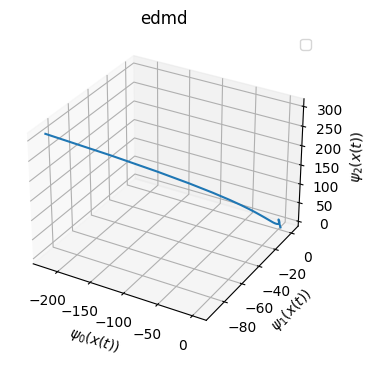

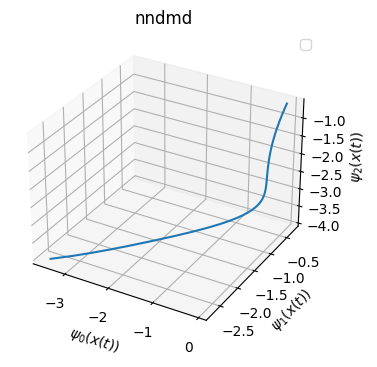

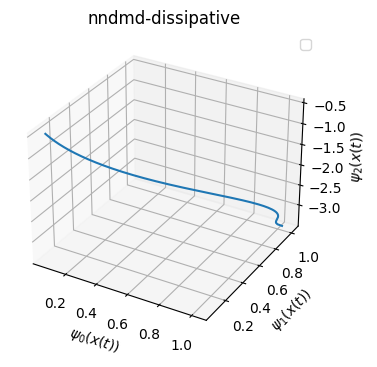

In [16]:
from mpl_toolkits.mplot3d import Axes3D

phi_edmd_test = model_edmd.psi(Xtest.T)
phi_nn_test = model.psi(Xtest.T)
phi_nn_d_test = model_d.psi(Xtest.T)
    
title_list = ['edmd','nndmd','nndmd-dissipative']
phi_list = [phi_edmd_test, phi_nn_test, phi_nn_d_test]

for i in range(3):
    phi = phi_list[i]
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(np.real(phi)[0,:],np.real(phi)[1,:],np.real(phi)[2,:])
    ax.set_xlabel(r'$\psi_0(x(t))$')
    ax.set_ylabel(r'$\psi_1(x(t))$')
    ax.set_zlabel(r'$\psi_2(x(t))$')
    
    plt.title(title_list[i])
    plt.legend(loc='best')

## Access the matrices related to Koopman operator

In [17]:
model.A.shape

(3, 3)

In [18]:
model.C.shape

(2, 3)

In [19]:
model.W.shape

(2, 3)